In [1]:
import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from IPython import display
import imageio
import numpy as np
import pandas as pd

import grid_world as _
from grid_world.envs.grid_world_env_v6 import GridWorldEnv_v6
import gymnasium as gym
from gymnasium.wrappers import ResizeObservation

import torch
import torch.nn as nn
from torchvision import transforms
from resnet.models import ResNet

import ray
from ray import tune
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.algorithm import Algorithm
from ray.tune.registry import register_env

In [2]:
ENV = 'grid_world/GridWorld-v6'
RASTER_DIR = Path('/home/ben/raster/cost_surfaces/10km_112nat_336reg_672loc/')
MAX_DISTANCE = 50   # max starting distance of agent to target in both dimensions
OBS_SIZE = 112      # observation width and height
DISTANCE_GOAL = 10  # proximity of agent to target required for episode termination
OBS_RADIUS = 5      # size of circle on obs which represents agent and target
MAX_STEPS = 500     # maximum number of agent steps in an episode
CHECKPOINT = '/home/ben/ray_results/PPO_GridWorldEnv_v6_2023-11-29_07-58-52pxjvs34x/checkpoint_000191'

In [3]:
national = np.load(RASTER_DIR.joinpath('national.npy'))
regional = np.load(RASTER_DIR.joinpath('regional.npy'))
local = np.load(RASTER_DIR.joinpath('local.npy'))
no_go = np.load(RASTER_DIR.joinpath('no_go.npy'))

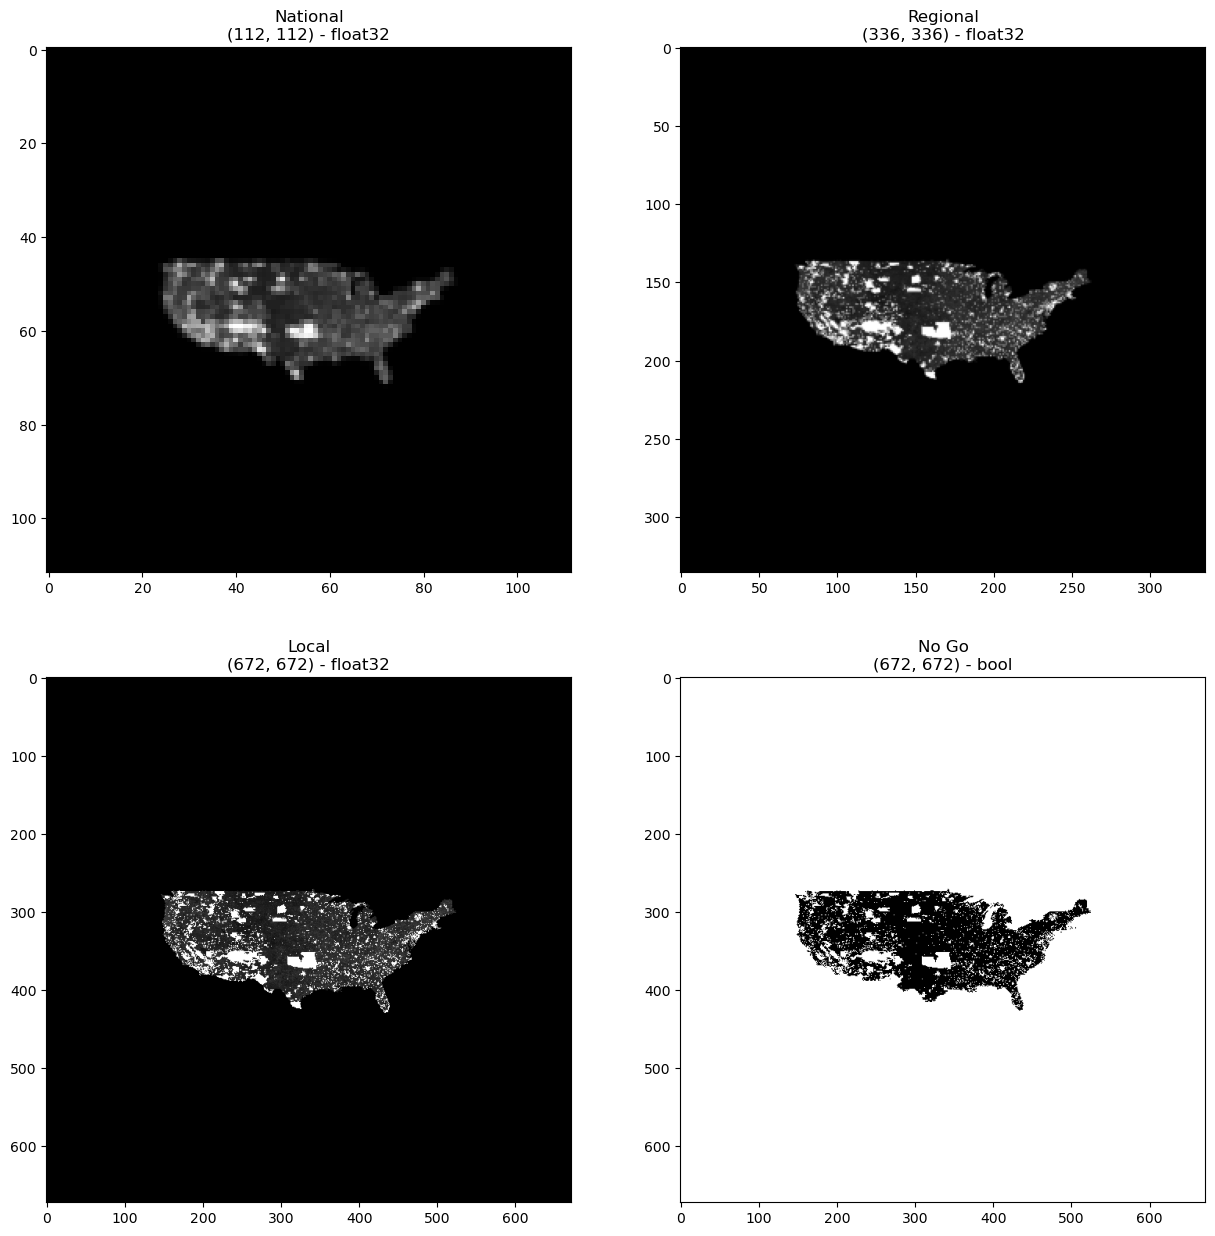

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

ax[0,0].set_title('National\n{} - {}'.format(national.shape, national.dtype))
ax[0,0].imshow(national, cmap='gray')

ax[0,1].imshow(regional, cmap='gray')
ax[0,1].set_title('Regional\n{} - {}'.format(regional.shape, regional.dtype))

ax[1,0].imshow(local, cmap='gray')
ax[1,0].set_title('Local\n{} - {}'.format(local.shape, local.dtype))

ax[1,1].imshow(no_go, cmap='gray')
ax[1,1].set_title('No Go\n{} - {}'.format(no_go.shape, no_go.dtype))

plt.show()

In [5]:
env_config = {
    'env': ENV,
    'size': OBS_SIZE,
    'max_distance': MAX_DISTANCE,
    'start': None,
    'target': None,
    'distance_goal': DISTANCE_GOAL,
    'obs_radius': OBS_RADIUS,
    'render_mode': None,
    'national': national,
    'regional': regional,
    'local': local,
    'no_go': no_go,
    'max_steps': MAX_STEPS
    }

env = gym.make(ENV, env_config=env_config)
observation, info = env.reset()
env.close()

print(observation.shape)
print(observation.min())
print(observation.max())
print(observation.dtype)
print(env.action_space)

(9, 112, 112)
0.0
1.0
float32
Discrete(8)


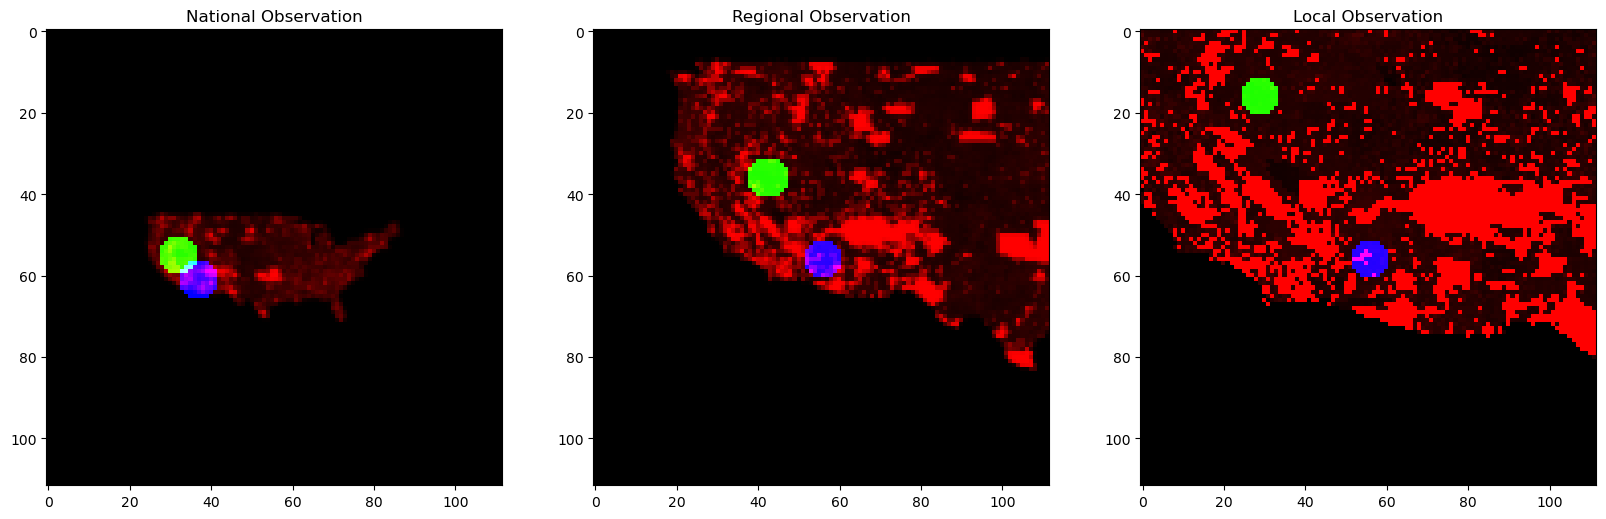

In [6]:
national_obs = observation[:3,:,:]
regional_obs = observation[3:6,:,:]
local_obs = observation[6:,:,:]

national_img = np.moveaxis(national_obs, 0, -1)
regional_img = np.moveaxis(regional_obs, 0, -1)
local_img = np.moveaxis(local_obs, 0, -1)

fig, ax = plt.subplots(ncols=3, figsize=(20,10))

ax[0].set_title('National Observation')
ax[0].margins(0.01)
ax[0].imshow(national_img)

ax[1].set_title('Regional Observation')
ax[1].margins(0.01)
ax[1].imshow(regional_img)

ax[2].set_title('Local Observation')
ax[2].margins(0.01)
ax[2].imshow(local_img)

plt.show()

In [12]:
class CustomTorchModel(TorchModelV2, nn.Module):
    
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super(CustomTorchModel, self).__init__(obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        self.encoder = ResNet(in_channels=9, num_blocks=3)
        self.policy_fc = nn.Linear(in_features=256, out_features=action_space.n)
        self.value_fc = nn.Linear(in_features=256, out_features=1)
    
    def forward(self, input_dict, state, seq_lens):
        # is_training = input_dict.is_training
        observation = input_dict['obs']

        assert isinstance(observation, torch.Tensor)
        # assert observation.shape[]
        # tensor = torch.tensor(observation).to(torch.float)
        # tensor = torch.tensor(observation, dtype=torch.float)
        # tensor = torch.moveaxis(observation, -1, 1)
        encoded_obs = self.encoder(observation)
        logits = self.policy_fc(encoded_obs)
        self.state_value = self.value_fc(encoded_obs)

        return logits, []
    
    def value_function(self):
        return self.state_value.squeeze(-1)

In [7]:
# agent = CustomTorchModel(
#     obs_space=observation.shape,
#     action_space=env.action_space,
#     num_outputs=
#     )

In [8]:
ray.shutdown()

In [9]:
# agent = Algorithm.from_checkpoint(
#     '/home/ben/ray_results/PPO_GridWorldEnv_v6_2023-12-05_12-15-589dh1hxfi/checkpoint_000046'
# )

In [10]:
# from ray.rllib.policy.policy import Policy

# policy = Policy.from_checkpoint('/home/ben/ray_results/PPO_GridWorldEnv_v6_2023-12-05_12-15-589dh1hxfi/checkpoint_000046')

In [13]:
torch_model = torch.load('/home/ben/gym/grid/trained_model/model.pt')

In [11]:
np.expand_dims(observation, axis=0).shape

(1, 9, 112, 112)

In [12]:
with torch.no_grad():
    results = torch_model(
        input_dict={'obs': torch.from_numpy(np.expand_dims(observation, axis=0)), 'is_training':False},
        state=[torch.tensor(0)],  # dummy value
        seq_lens=torch.tensor(0),  # dummy value
    )

print(results)

(tensor([[-4.0241,  5.2774, -1.0983, -9.1882, -0.8116, -6.2278, -1.2028, -1.7327]]), [tensor(0)])


In [14]:
type(results)

tuple

In [19]:
results[0].argmax().item()

tensor(1)